In [1]:
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import PIL
import math
from bpemb import BPEmb
from torch import nn
from image_caption_dataset import ImageCaptionDataset
from multi_bpe import MultiBPE
from multimodal_model import MMLSTM, BenchmarkLSTM, BenchmarkCustomLSTM
from torch.utils.data import DataLoader
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import multimodal_model
# mm_model = MMLSTM(is_multimodal=False).to(device)
# mm_model.load_state_dict(torch.load('./saved_models/monomodal_model_50000_0.00025_6'))


In [2]:
multi_bpe = MultiBPE()

In [3]:
def generate_seq_with_img(model, img_path, seed, origin_size, size, temperature=1.0):
    """
    :param model: The complete RNN language model
    :param seed: The first few wordas of the sequence to start generating from
    :param size: The total size of the sequence to generate
    :param temperature: This controls how much we follow the probabilities provided by the network. For t=1.0 we just
        sample directly according to the probabilities. Lower temperatures make the high-probability words more likely
        (providing more likely, but slightly boring sentences) and higher temperatures make the lower probabilities more
        likely (resulting is weirder sentences). For temperature=0.0, the generation is _greedy_, i.e. the word with the
        highest probability is always chosen.
    :return: A list of integers representing a samples sentence
    """

    ls = seed.shape[0]

    tokens = seed.to(device)
    img = process_img(img_path).to(device)
    for i in range(origin_size+1, size):
        probs = model(tokens[None,:], img)

        # Extract the i-th probability vector and sample an index from it
        next_token = sample_logits(probs[0, i-1, :], temperature=temperature)
        
        tokens[i] = next_token

    return tokens

In [4]:
def process_img(image_path): 
    transform = torchvision.transforms.Compose([
        # Resize image to 224 x 224 as required by most vision models
        torchvision.transforms.Resize(
            size=(224, 224)
        ),
        # Convert PIL image to tensor with image values in [0, 1]
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    im = PIL.Image.open(image_path)
    image = im.convert('RGB')
    image = transform(image)
    
    return image.view(1, image.size(0), image.size(1), image.size(2))

In [5]:
def generate_seq(model, seed, origin_size, size, temperature=1.0):
    """
    :param model: The complete RNN language model
    :param seed: The first few wordas of the sequence to start generating from
    :param size: The total size of the sequence to generate
    :param temperature: This controls how much we follow the probabilities provided by the network. For t=1.0 we just
        sample directly according to the probabilities. Lower temperatures make the high-probability words more likely
        (providing more likely, but slightly boring sentences) and higher temperatures make the lower probabilities more
        likely (resulting is weirder sentences). For temperature=0.0, the generation is _greedy_, i.e. the word with the
        highest probability is always chosen.
    :return: A list of integers representing a samples sentence
    """

    ls = seed.shape[0]

    tokens = seed.to(device)
    
    for i in range(origin_size+1, size):
        if not isinstance(model, multimodal_model.MMLSTM):
            probs = model(tokens[None,:])
        else:
            probs = model.forward_text(tokens[None,:])

        # Extract the i-th probability vector and sample an index from it
        next_token = sample_logits(probs[0, i-1, :], temperature=temperature)
        
        tokens[i] = next_token

    return tokens

In [6]:
def sample_logits(preds, temperature=1.0):
    """
    Sample an index from a logit vector.
    :param preds:
    :param temperature:
    :return:
    """

    if temperature == 0.0:
        return torch.argmax(preds)

    preds = preds / temperature
    preds = preds - torch.logsumexp(preds,0)
    
    choice = np.random.choice(len(preds), 1, p=np.exp(preds.detach().cpu().numpy()))
    choice = torch.tensor(choice).to(device)
    return choice

In [7]:
def get_n_samples(model, prompt, n, maxlen=20, temperature=1.0):
    seed = multi_bpe.encode(prompt, maxlen)
    original_size = seed.index(2) - 1
    for i in range(n):
        new_sequence = generate_seq(model, 
                                    seed=torch.tensor(seed), 
                                    origin_size=original_size, 
                                    size=20, 
                                    temperature=temperature)
        print(multi_bpe.decode(new_sequence.tolist()))
        

In [8]:
def get_n_samples_with_img(model, img_path, prompt, n, maxlen=20, temperature=1.0):
    seed = multi_bpe.encode(prompt, maxlen)
    original_size = seed.index(2) - 1
    for i in range(n):
        new_sequence = generate_seq_with_img(model, 
                                    img_path = img_path,
                                    seed=torch.tensor(seed), 
                                    origin_size=original_size, 
                                    size=20, 
                                    temperature=temperature)
        print(multi_bpe.decode(new_sequence.tolist()))

In [9]:
df = pd.read_csv('./data/' + 'ml_stacked_data.csv')
cat_img = './images/black_white_cat_img.jpeg'

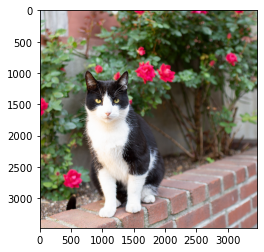

In [10]:
from matplotlib import pyplot as plt
I = plt.imread(cat_img)
plt.imshow(I)

In [55]:
%%capture
mm = 'finetuned_multimodal_lstm'#"multimodal_lstm_200000_1.0_15v5"
mm_model = MMLSTM(is_multimodal=True, train_visual_module=False).to(device)
mm_model.load_state_dict(torch.load(f'./saved_models/{mm}'))
mm_model.eval()

In [12]:
get_n_samples(mm_model, "", n=1, maxlen=40, temperature=0.5)

a man is laying a black and a black and a black and black and a black and


In [59]:
get_n_samples_with_img(mm_model, cat_img, " ", n=5, maxlen=10, temperature=0.5)

no no . no no . and i don't have to do . no no la de
ella me study hear that ? i don't have got a big many one . a ver
what's ? no había meses . ah . entonces me dijo . no me enti fresh .
no no . oh you know . no and what ? i don't just like ... no
el otro día no es . no . no es que es un poquito . y ya no


In [60]:
dog_img = './images/fridge_image.jpeg'
get_n_samples_with_img(mm_model, dog_img, "", n=10, maxlen=10, temperature=0.5)

no se me entienden material . de que tiene un poco más de que no lo que están
well you know it . no no . we can's not . and then . y después
it's a good thing . that's's all the way to go . and
no no eso es una niña . tú sabes . ya lo que yo quiero . si se
but i don't think . i don't know . you know i'm gonna
no es que estás a . no i don't need to be on the first .
the one . the only time . and then we'll be gonna go to go . that
i can's not . you know . what do you know . i'll be .
no la gente está en la universidad . pero yo no la gente . pero porque . pero you
that's the thing . and that . no i'm gonna go to go to go


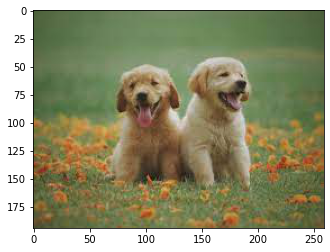

In [44]:
I = plt.imread(dog_img)
plt.imshow(I)

In [13]:
# get_n_samples_with_img(mm_model, test_img, "the flying avión", n=10, maxlen=10, temperature=0.5)

In [14]:
# get_n_samples_with_img(mm_model, test_img, "the dog", n=10, maxlen=10, temperature=.5)

In [15]:
# get_n_samples_with_img(mm_model, test_img, "el amigo", n=10, maxlen=10, temperature=0.5)

In [53]:
bm = 'benchmark_model_200000_1.0_15v7'
bm_model = BenchmarkLSTM().to(device)
bm_model.load_state_dict(torch.load(f'./saved_models/{bm}'))
bm_model.eval()

BenchmarkLSTM(
  (emb_layer): Embedding(320001, 300, padding_idx=320000)
  (lstm): LSTM(300, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=320001, bias=True)
)

In [54]:
get_n_samples(bm_model, "", n=10, maxlen=10, temperature=0.15)

a man riding a skateboard down a ramp...
a man riding a surf board on the ocean.
una persona en una tabla de surf en una ola.
a man is riding a skateboard on a ramp...
a man is standing on a tennis court holding a racquet.
a man and woman standing next to each other on a tennis court.
a man is standing in front of a laptop computer...
a man is riding a wave on a surfboard.
a man is riding a skateboard on a ramp...
a man riding a skateboard down a street..


In [ ]:
# multi_bpe = MultiBPE()
#Custom model, no image input
get_n_samples(mm_model, "", n=10, maxlen=10, temperature=0.15)

a man is standing in a large black and a black and black and a black and black and
un hombre de pie en un vestido de la parte de la mano de la cámara en la mano
a man in a black and a black and black and a black and a black and a black
a man is standing in a large open window.
un hombre está de pie en un hombre en un pequeño en el agua.
a man is standing next to a black and a black and a black and black and a black
a man in a black and a black and a black and black and a black and a black
un hombre de pie en un pequeño par de pie en un hombre en la parte de la mano


In [ ]:
#Custom model, no image input
get_n_samples(mm_model, "the cat", n=5, maxlen=10, temperature=0.7)

In [ ]:
###GITHUB!!!!!!!!!!!!!!

In [ ]:
target_tensor, decoder_hiddens = torch.ones((1, 10)).to(device), torch.ones((1,1,10)).to(device)
beam_decode(target_tensor, decoder_hiddens)